In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/prediction-modes"
sys.path.insert(0, ROOT_PATH)

In [2]:
from src.datasets.data_config import HINTSETS, DEFAULT_HINTSET
from src.datasets.oracle import Oracle, OracleRequest, TIMEOUT
from src.utils import get_logical_plan, get_full_plan

In [3]:
oracle = Oracle(f"{ROOT_PATH}/data/processed/JOB")

In [4]:
# the default value in our settings
DEFAULT_DOP = 64
TIMEOUT_REL = 2

In [5]:
GREEN = "#3f993c"
ORANGE = "#fcaa2f"
BLUE = "cyan"
RED = "#a00d30"

In [6]:
TIMEOUT_VAL = -1.5

In [7]:
def plot_hintsets_bar(hintsets, boosts, title, path_to_save, logscale=True):
    index = np.arange(len(hintsets))
    bar_width = 0.7

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(40, 15))
    
    timeout_index = [index[i] for i, boost in enumerate(boosts) if boost == 1/TIMEOUT_REL]

    degradation_index = [index[i] for i, boost in enumerate(boosts) if boost != 1/TIMEOUT_REL and boost < 1]
    degradation_vals = [-((1/boost)-1) for i, boost in enumerate(boosts) if boost != 1/TIMEOUT_REL and boost < 1]
    
    boost_index = [index[i] for i, boost in enumerate(boosts) if boost != 1/TIMEOUT_REL and boost >= 1]
    boost_vals = [boost-1 for i, boost in enumerate(boosts) if boost != 1/TIMEOUT_REL and boost >= 1]    

    if boost_index:
        boost_bars = ax.bar(boost_index, boost_vals, bar_width, label='Relative Boost', color=GREEN)
    if timeout_index:
        timeout_bars = ax.bar(timeout_index, [TIMEOUT_VAL for _ in timeout_index], bar_width, label='Timeout', color=RED)
    if degradation_index:
        degradation_bars = ax.bar(degradation_index, degradation_vals, bar_width, label='Relative Degradation', color=ORANGE)
    
    left_edge = index[0] - bar_width / 2
    right_edge = index[-1] + bar_width / 2
    ax.plot([left_edge, right_edge], [0.0, 0.0], color='white', linewidth=.5, linestyle='-')# label='Default Time', alpha=0.8)

    if logscale:
        ax.set_yscale("symlog")
        ax.set_ylabel('Relative Performance (log scale)',fontsize=26)
    else:
        y_min = np.floor(TIMEOUT_VAL)
        y_max = np.ceil(max(boost_vals))
        ax.set_ylim(y_min, y_max)        
        ax.set_ylabel('Relative Performance',fontsize=26)

    ax.set_xlabel('Hintset', fontsize=26)
    ax.set_title(title, fontsize=30)
    ax.set_xticks(index)
    ax.tick_params(axis='y', labelsize=26)
    ax.set_xticklabels(hintsets, rotation=90, fontsize=18)
    ax.legend(fontsize=26, loc="upper right")
    ax.grid(True, which='both', linestyle='-', linewidth=0.3)
    #plt.savefig(path_to_save, dpi=700)
    plt.show()

In [8]:
def plot_boosts_for_all_hintsets(query_names, logscale=False):
    for q_n in query_names:
        custom_times, boosts = [], []
        
        for hs in HINTSETS:
            def_time = oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=DEFAULT_HINTSET, dop=DEFAULT_DOP))
            custom_time = oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=DEFAULT_DOP))

            if custom_time >= TIMEOUT:
                custom_time = TIMEOUT_REL * def_time

            custom_times.append(custom_time)
            boosts.append(def_time / custom_time)

        plot_hintsets_bar(
            hintsets=HINTSETS, 
            boosts=boosts, 
            title=f"Relative times for {q_n}",
            path_to_save=None,
            logscale=logscale
        )

In [13]:
def estimate_negative_impact(from_q_n, to_q_n, boost_threshold=1.1):
    to_potential_times = []

    from_def_time = oracle.get_execution_time(OracleRequest(query_name=from_q_n, hintset=DEFAULT_HINTSET, dop=DEFAULT_DOP))
    to_def_time = oracle.get_execution_time(OracleRequest(query_name=to_q_n, hintset=DEFAULT_HINTSET, dop=DEFAULT_DOP))
    
    for hs in HINTSETS:
        to_custom_time = oracle.get_execution_time(OracleRequest(query_name=to_q_n, hintset=hs, dop=DEFAULT_DOP))
        if to_custom_time >= TIMEOUT:
            to_custom_time = TIMEOUT_REL * to_def_time

        from_custom_time = oracle.get_execution_time(OracleRequest(query_name=from_q_n, hintset=hs, dop=DEFAULT_DOP))
        
        boost_is_enough = (from_def_time / from_custom_time > boost_threshold)
        if boost_is_enough:
            to_potential_times.append(to_custom_time)

    n_timeouts = sum([t == TIMEOUT_REL * to_def_time for t in to_potential_times])

    print(f"EXPECTED DEGRADATION ON {to_q_n} DUE TO {from_q_n} IS ABOUT x{np.mean(to_potential_times) / to_def_time:0.9f}")        
    print(f"THE PORTION OF TIMEOUTS IS {n_timeouts} / {len(to_potential_times)}")

In [14]:
# query_names = ["6a", "6e", "6b", "6c", "6d",]
# len(set([get_full_plan(query_name=q_n, oracle=oracle, hintset=0, dop=64) for q_n in query_names])),
# len(set([get_logical_plan(query_name=q_n, oracle=oracle, hintset=0, dop=64) for q_n in query_names])),


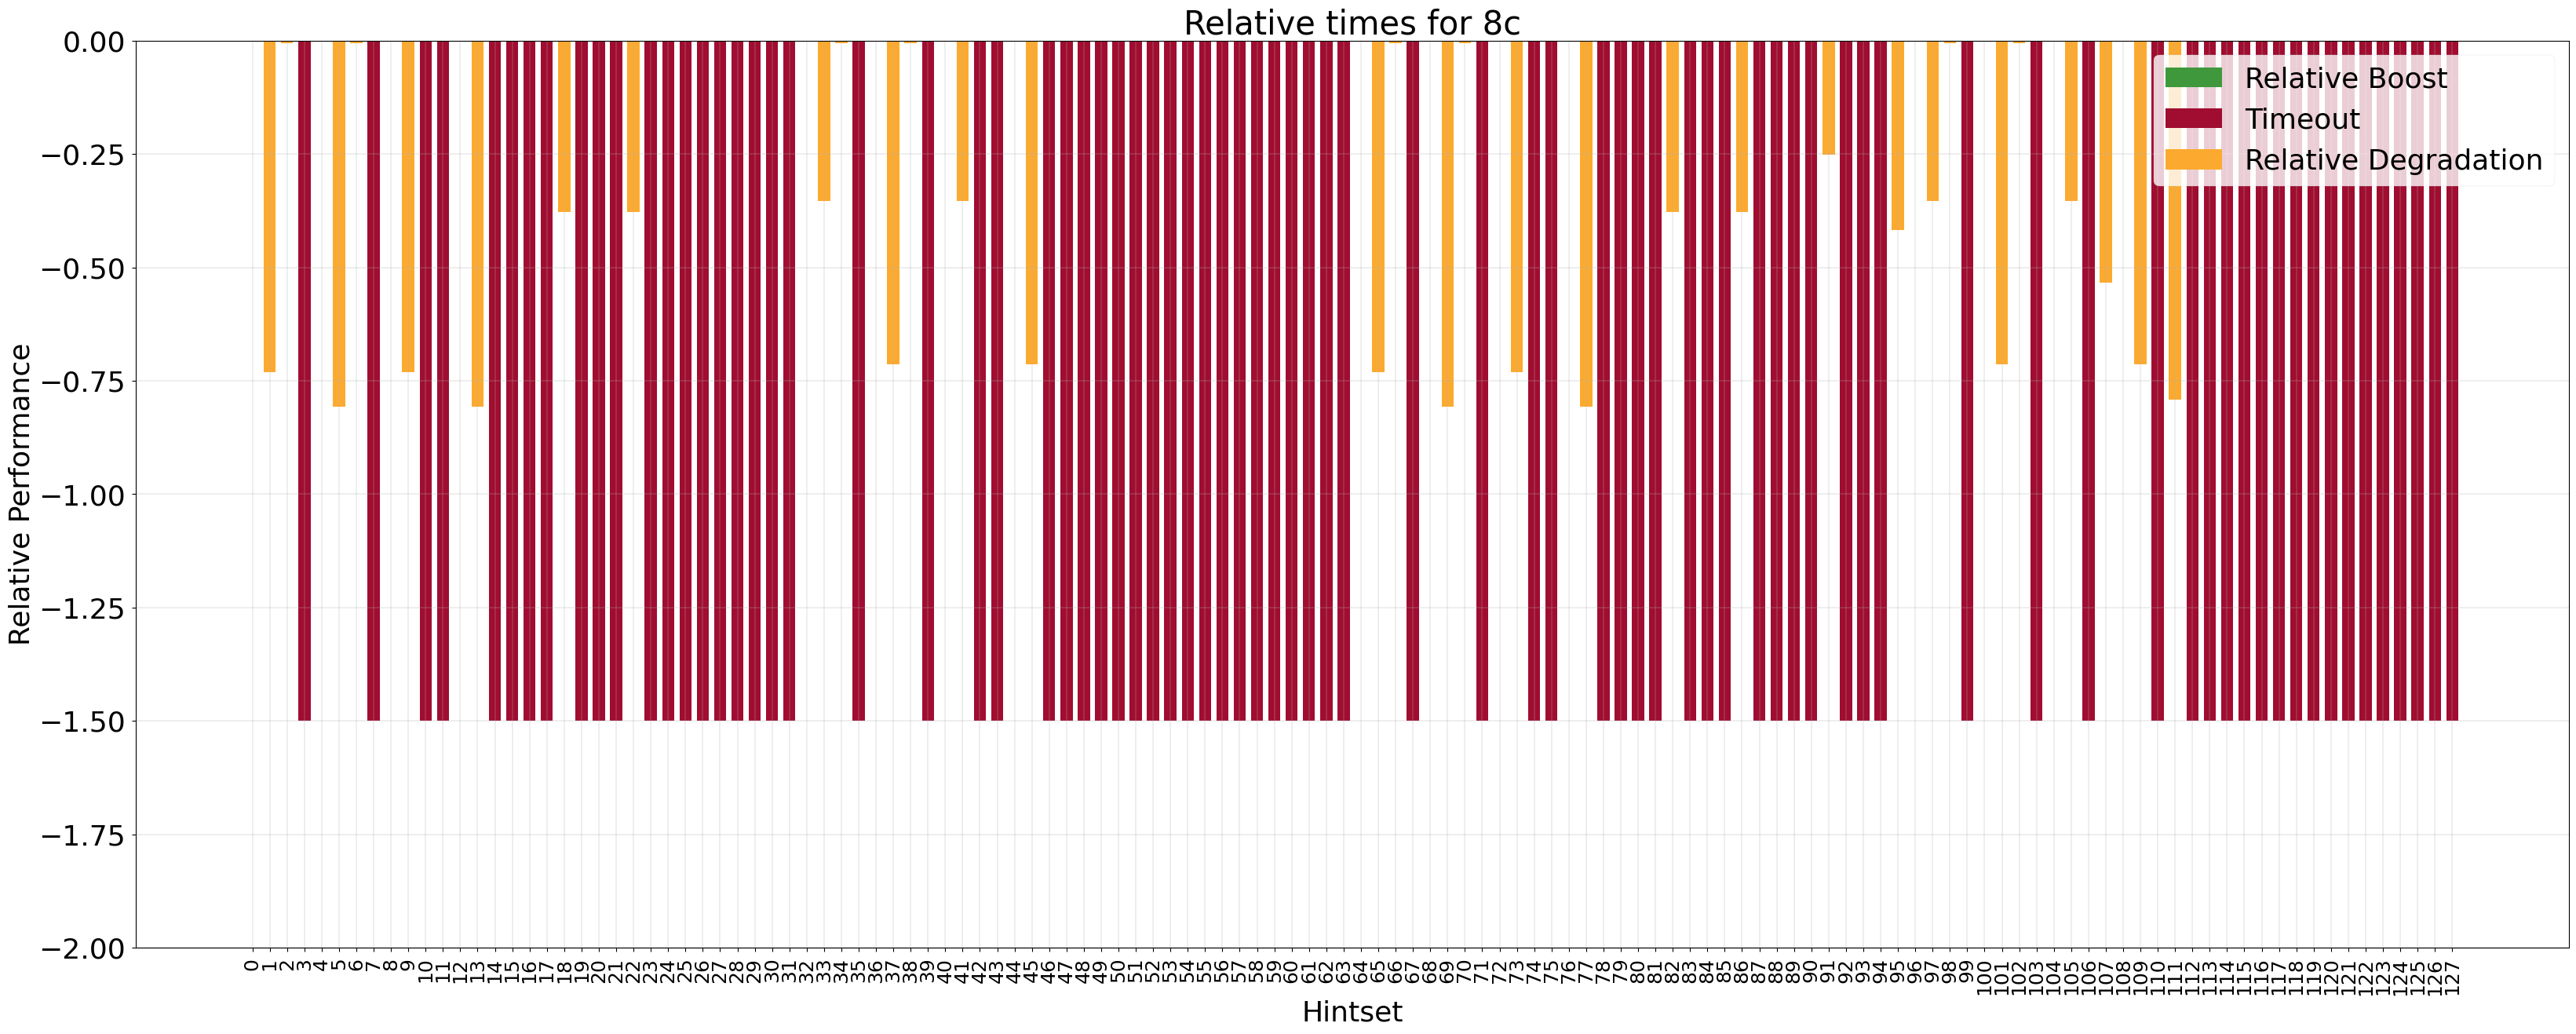

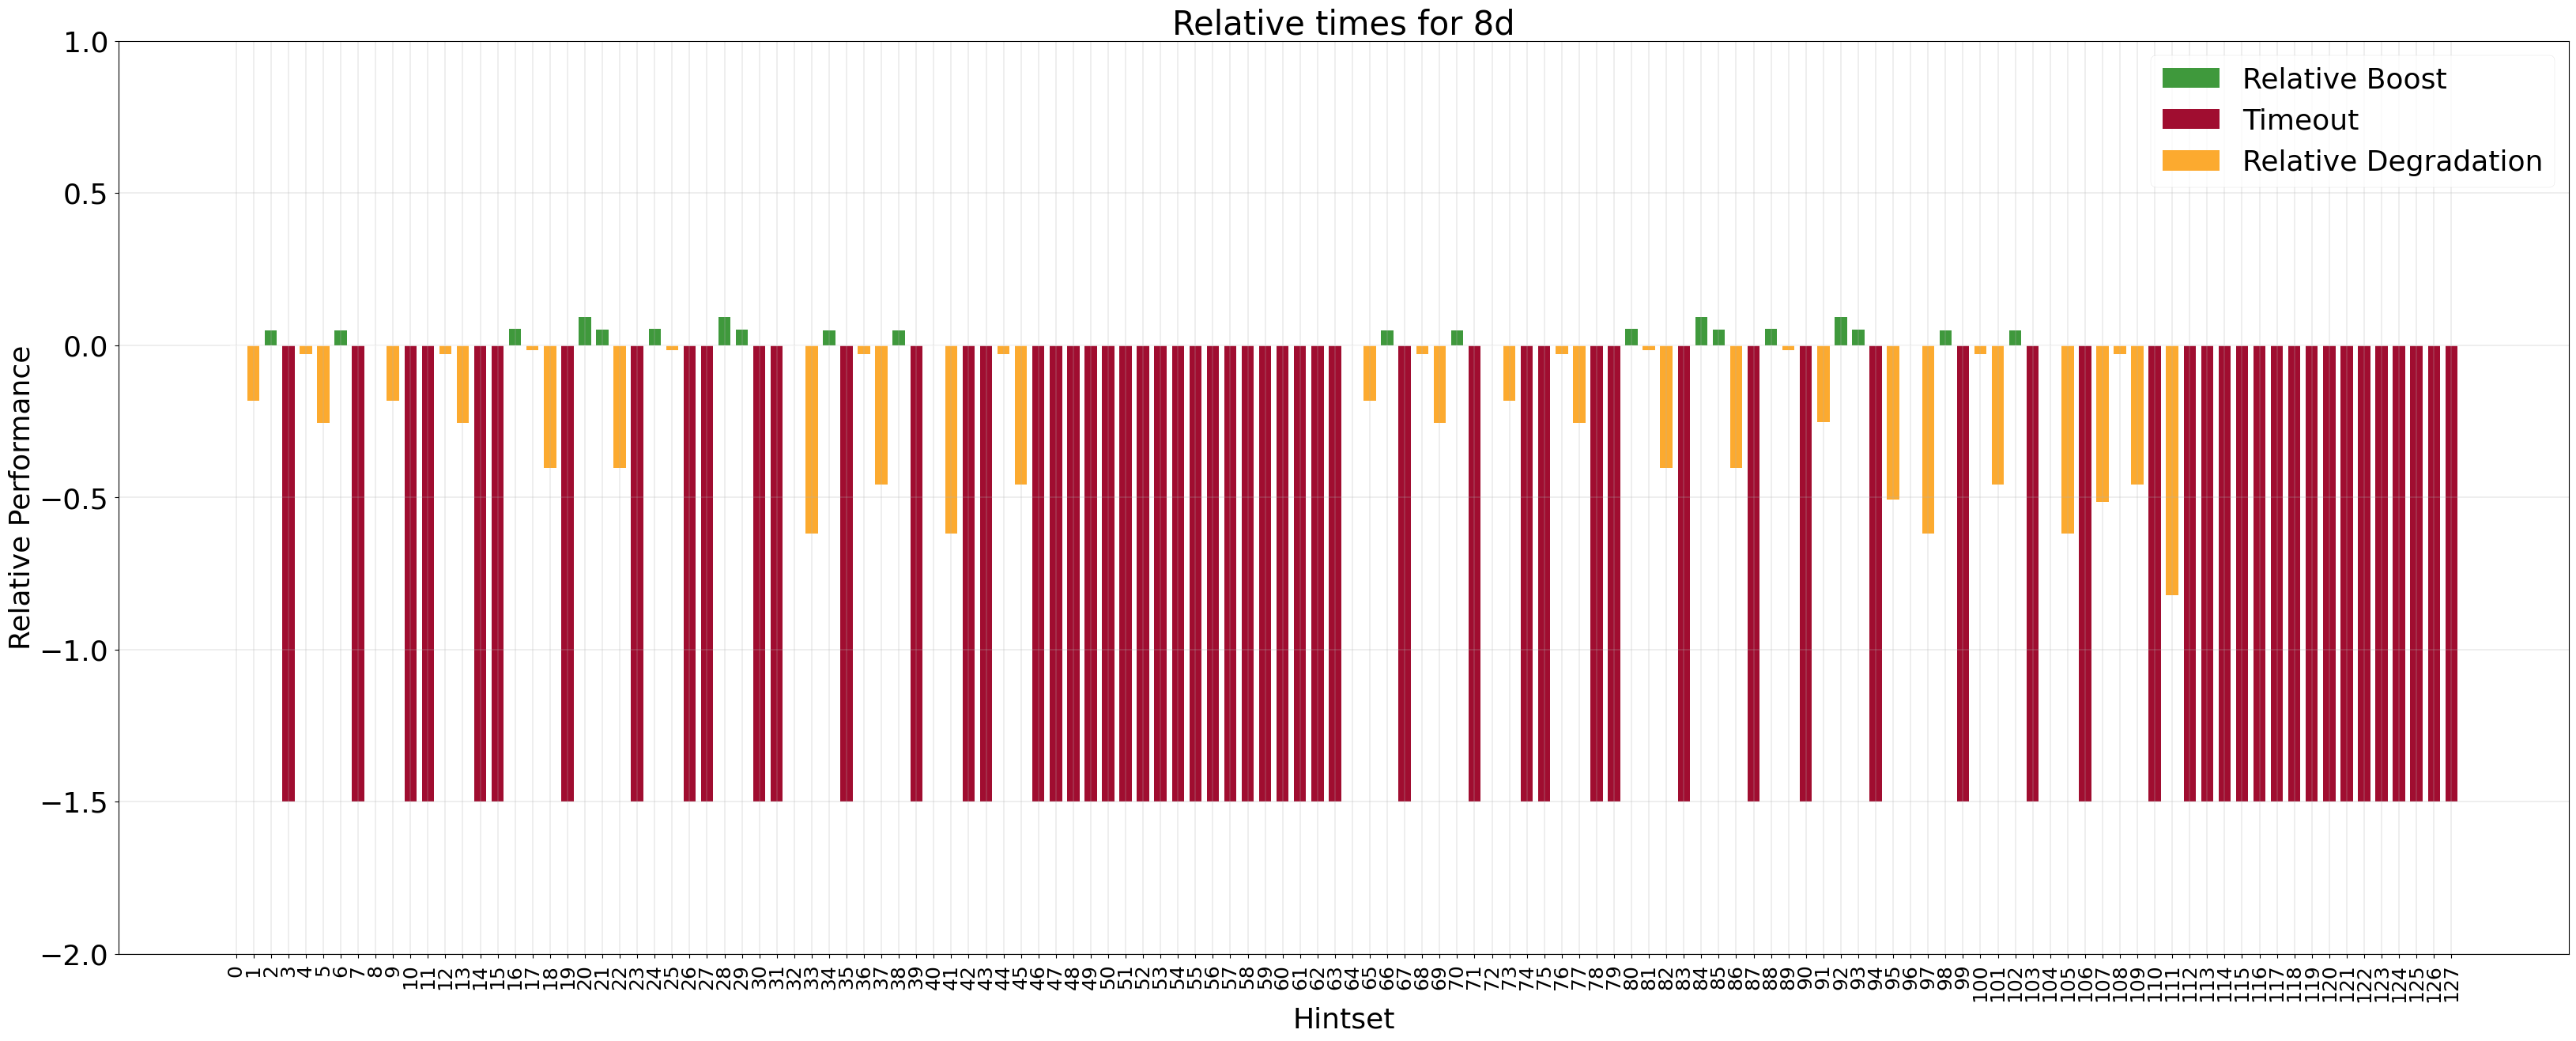

In [15]:
DEFAULT_DOP = 1
plot_boosts_for_all_hintsets(["8c", "8d"], logscale=False)

EXPECTED DEGRADATION ON 16d DUE TO 16b IS ABOUT x1.327994775
THE PORTION OF TIMEOUTS IS 6 / 30


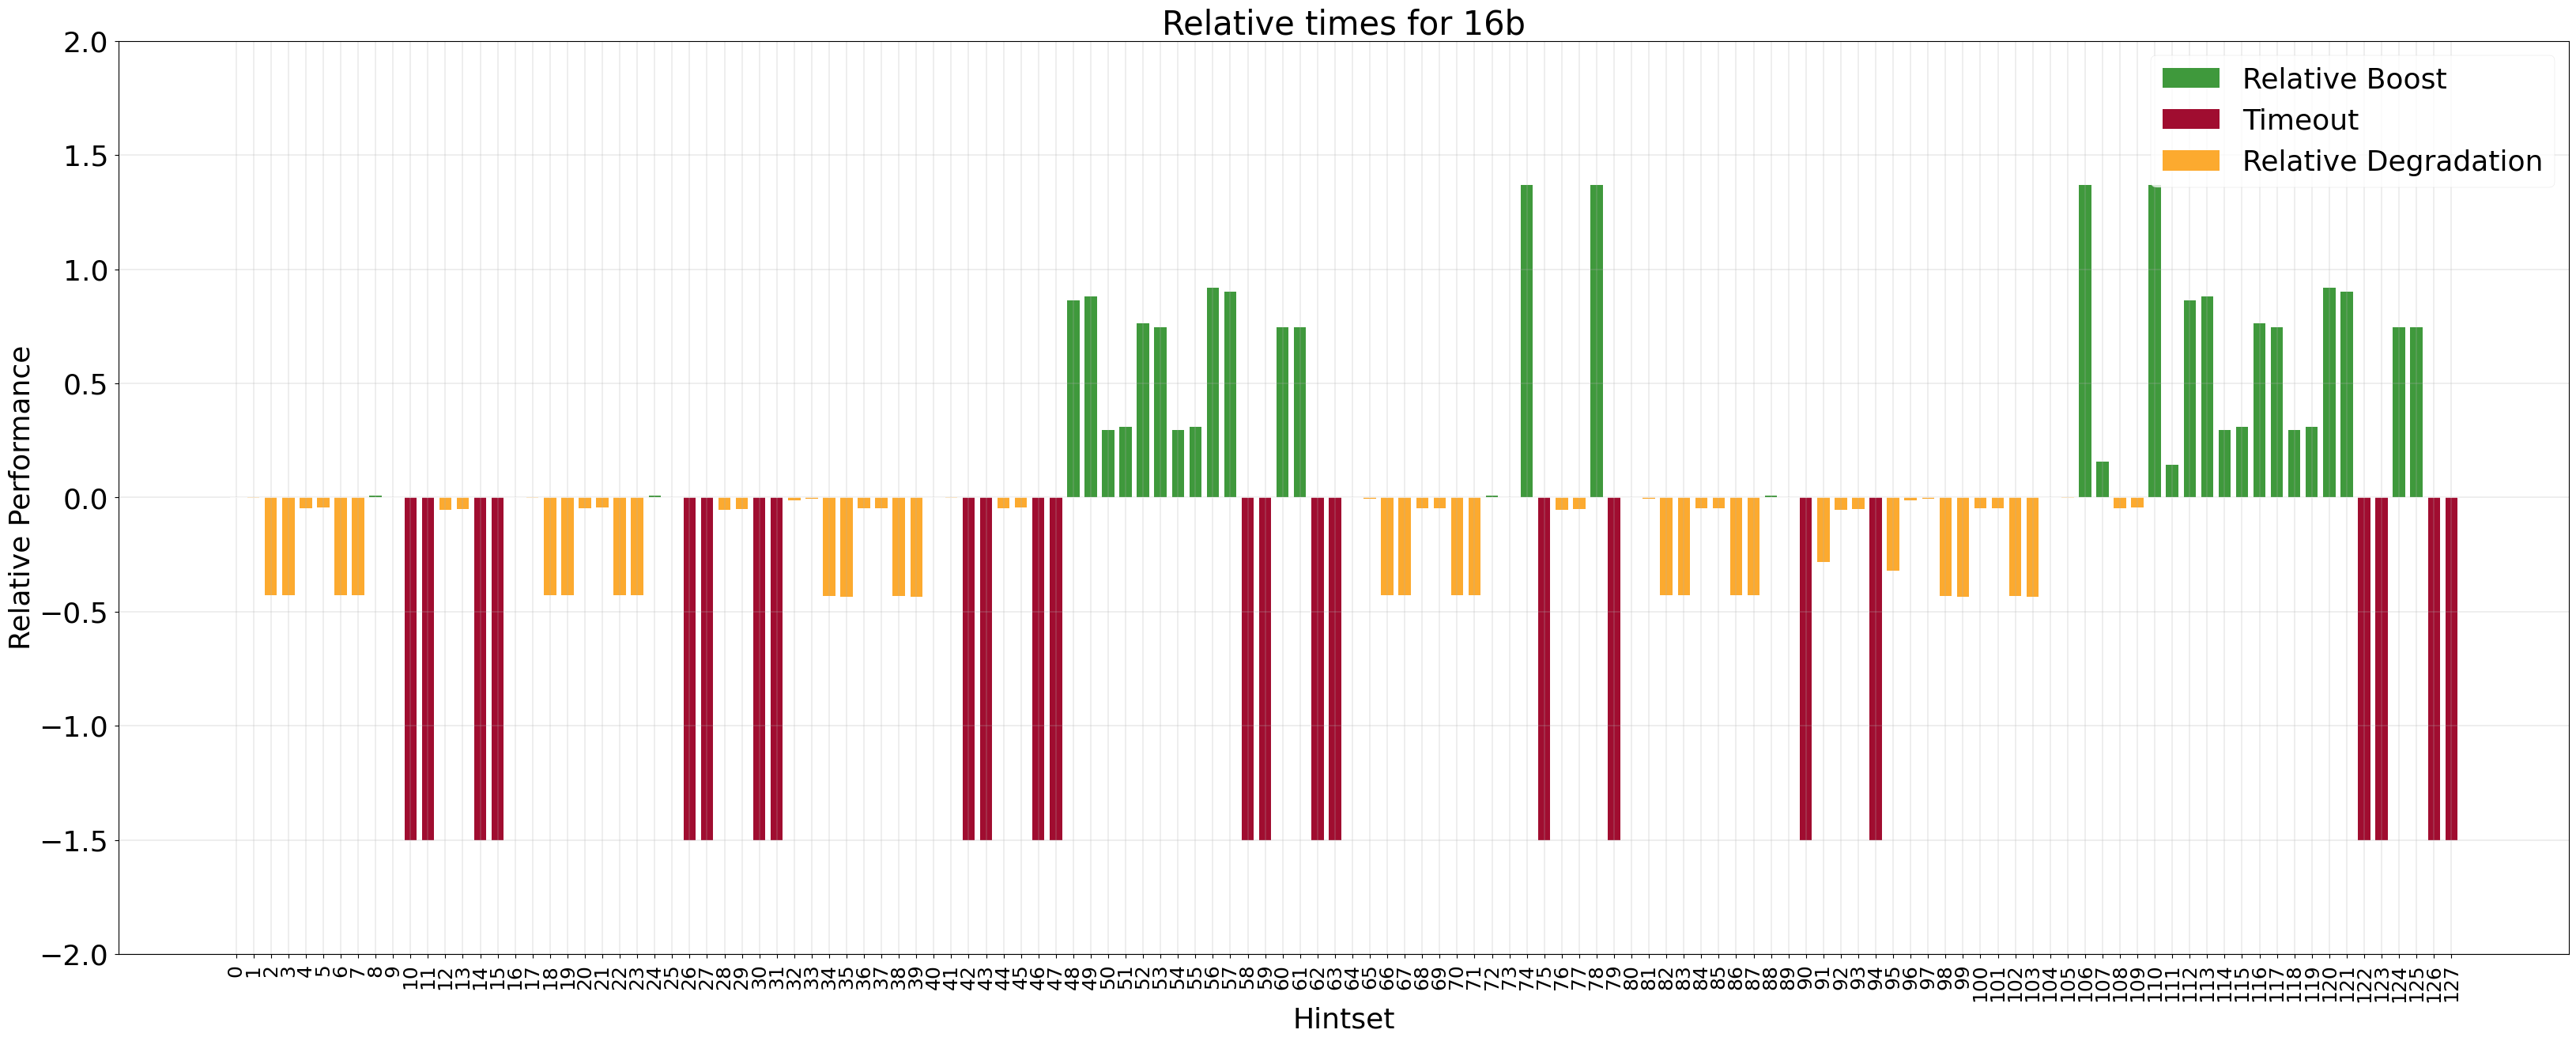

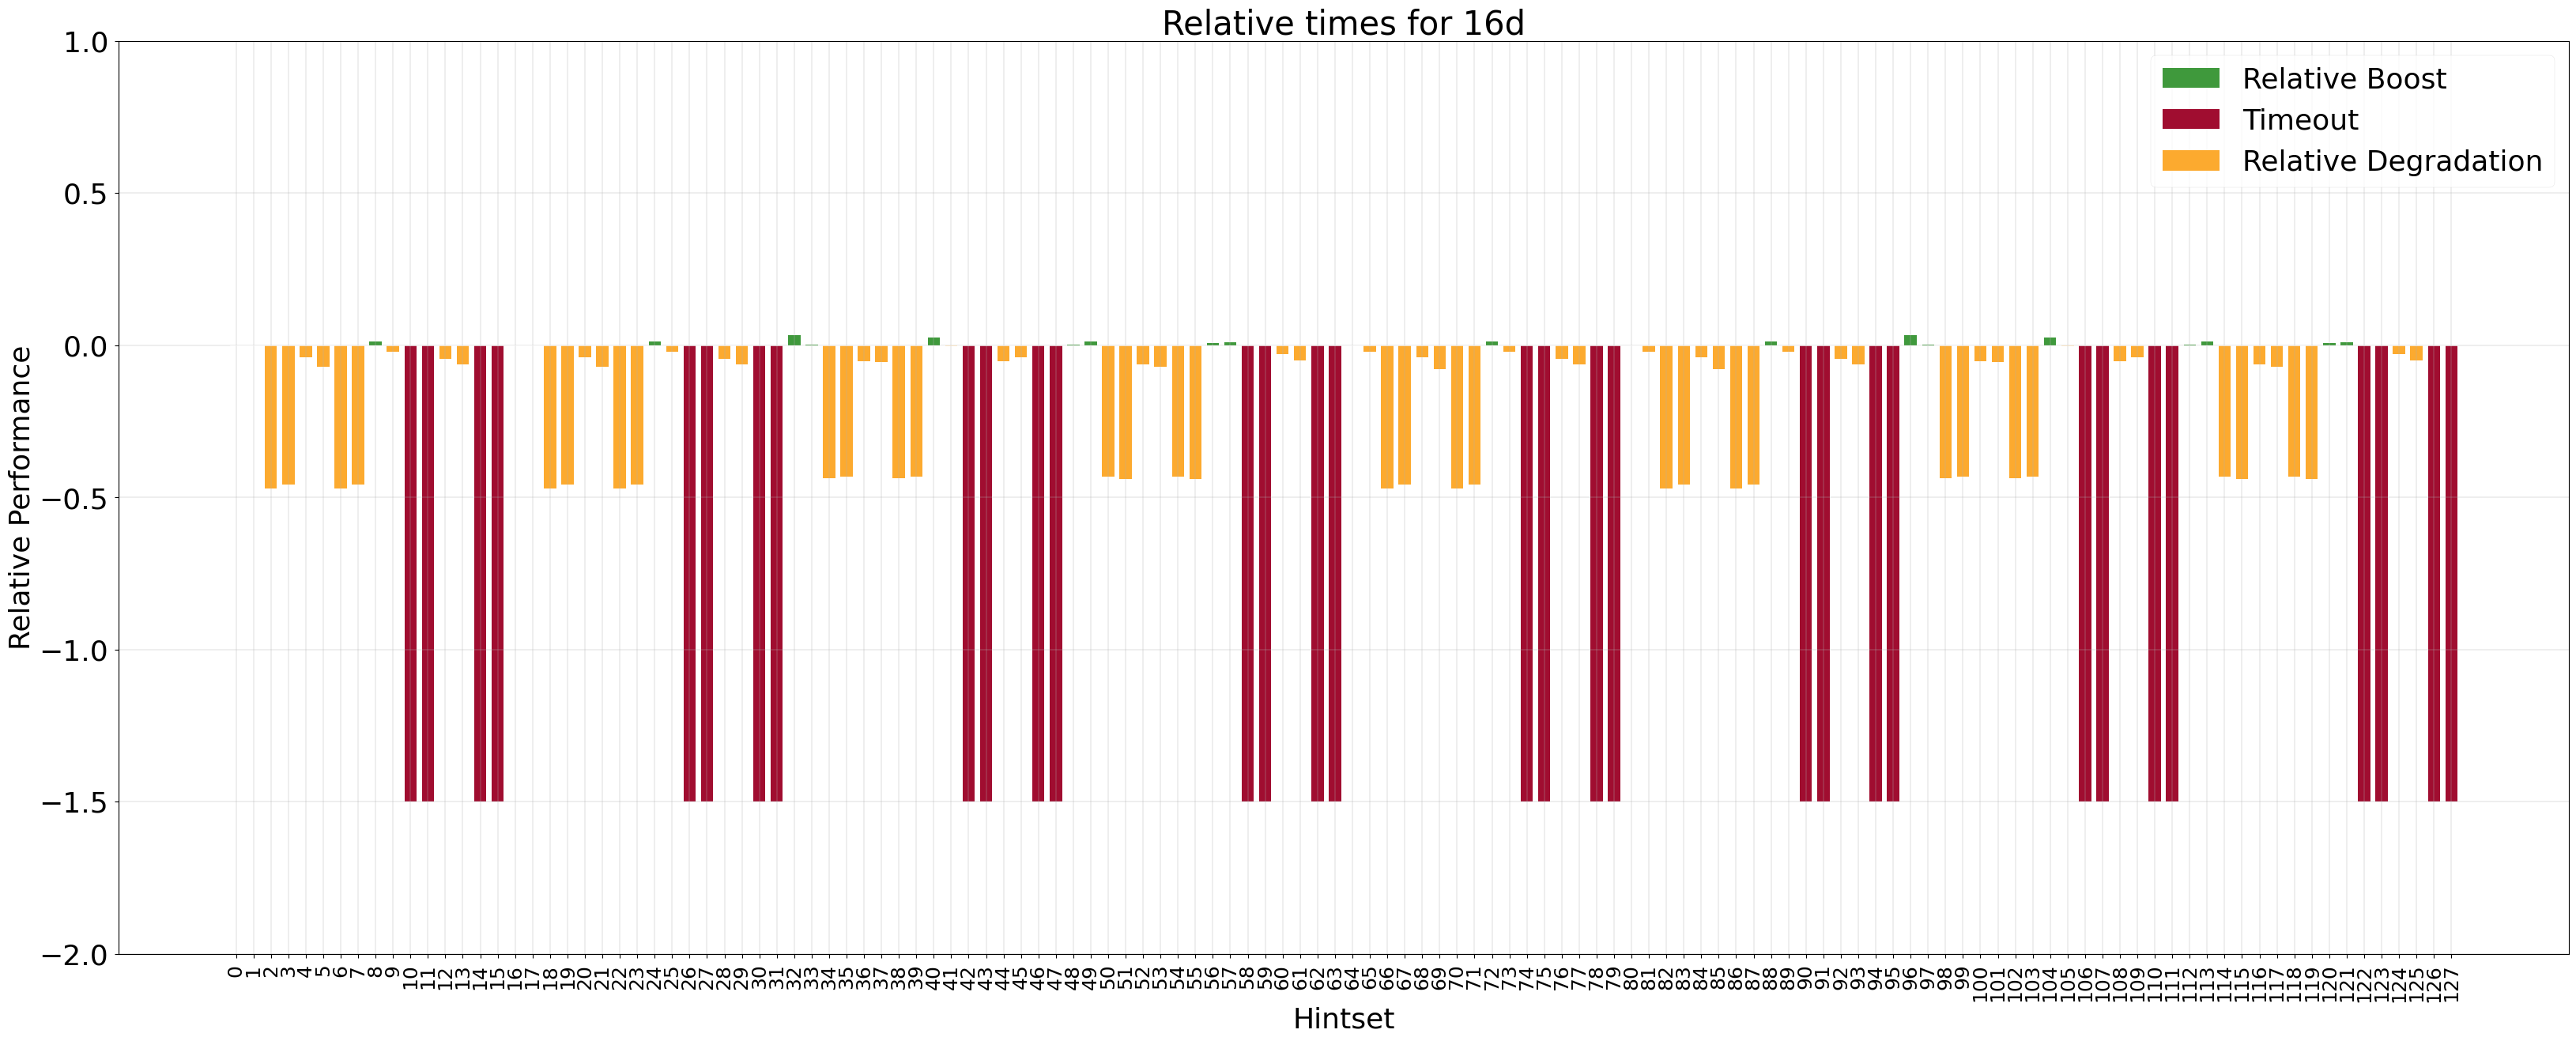

In [16]:
DEFAULT_DOP = 64
estimate_negative_impact("16b", "16d")
plot_boosts_for_all_hintsets(["16b", "16d"], logscale=False)

EXPECTED DEGRADATION ON 6d DUE TO 6b IS ABOUT x1.036644040
THE PORTION OF TIMEOUTS IS 4 / 38


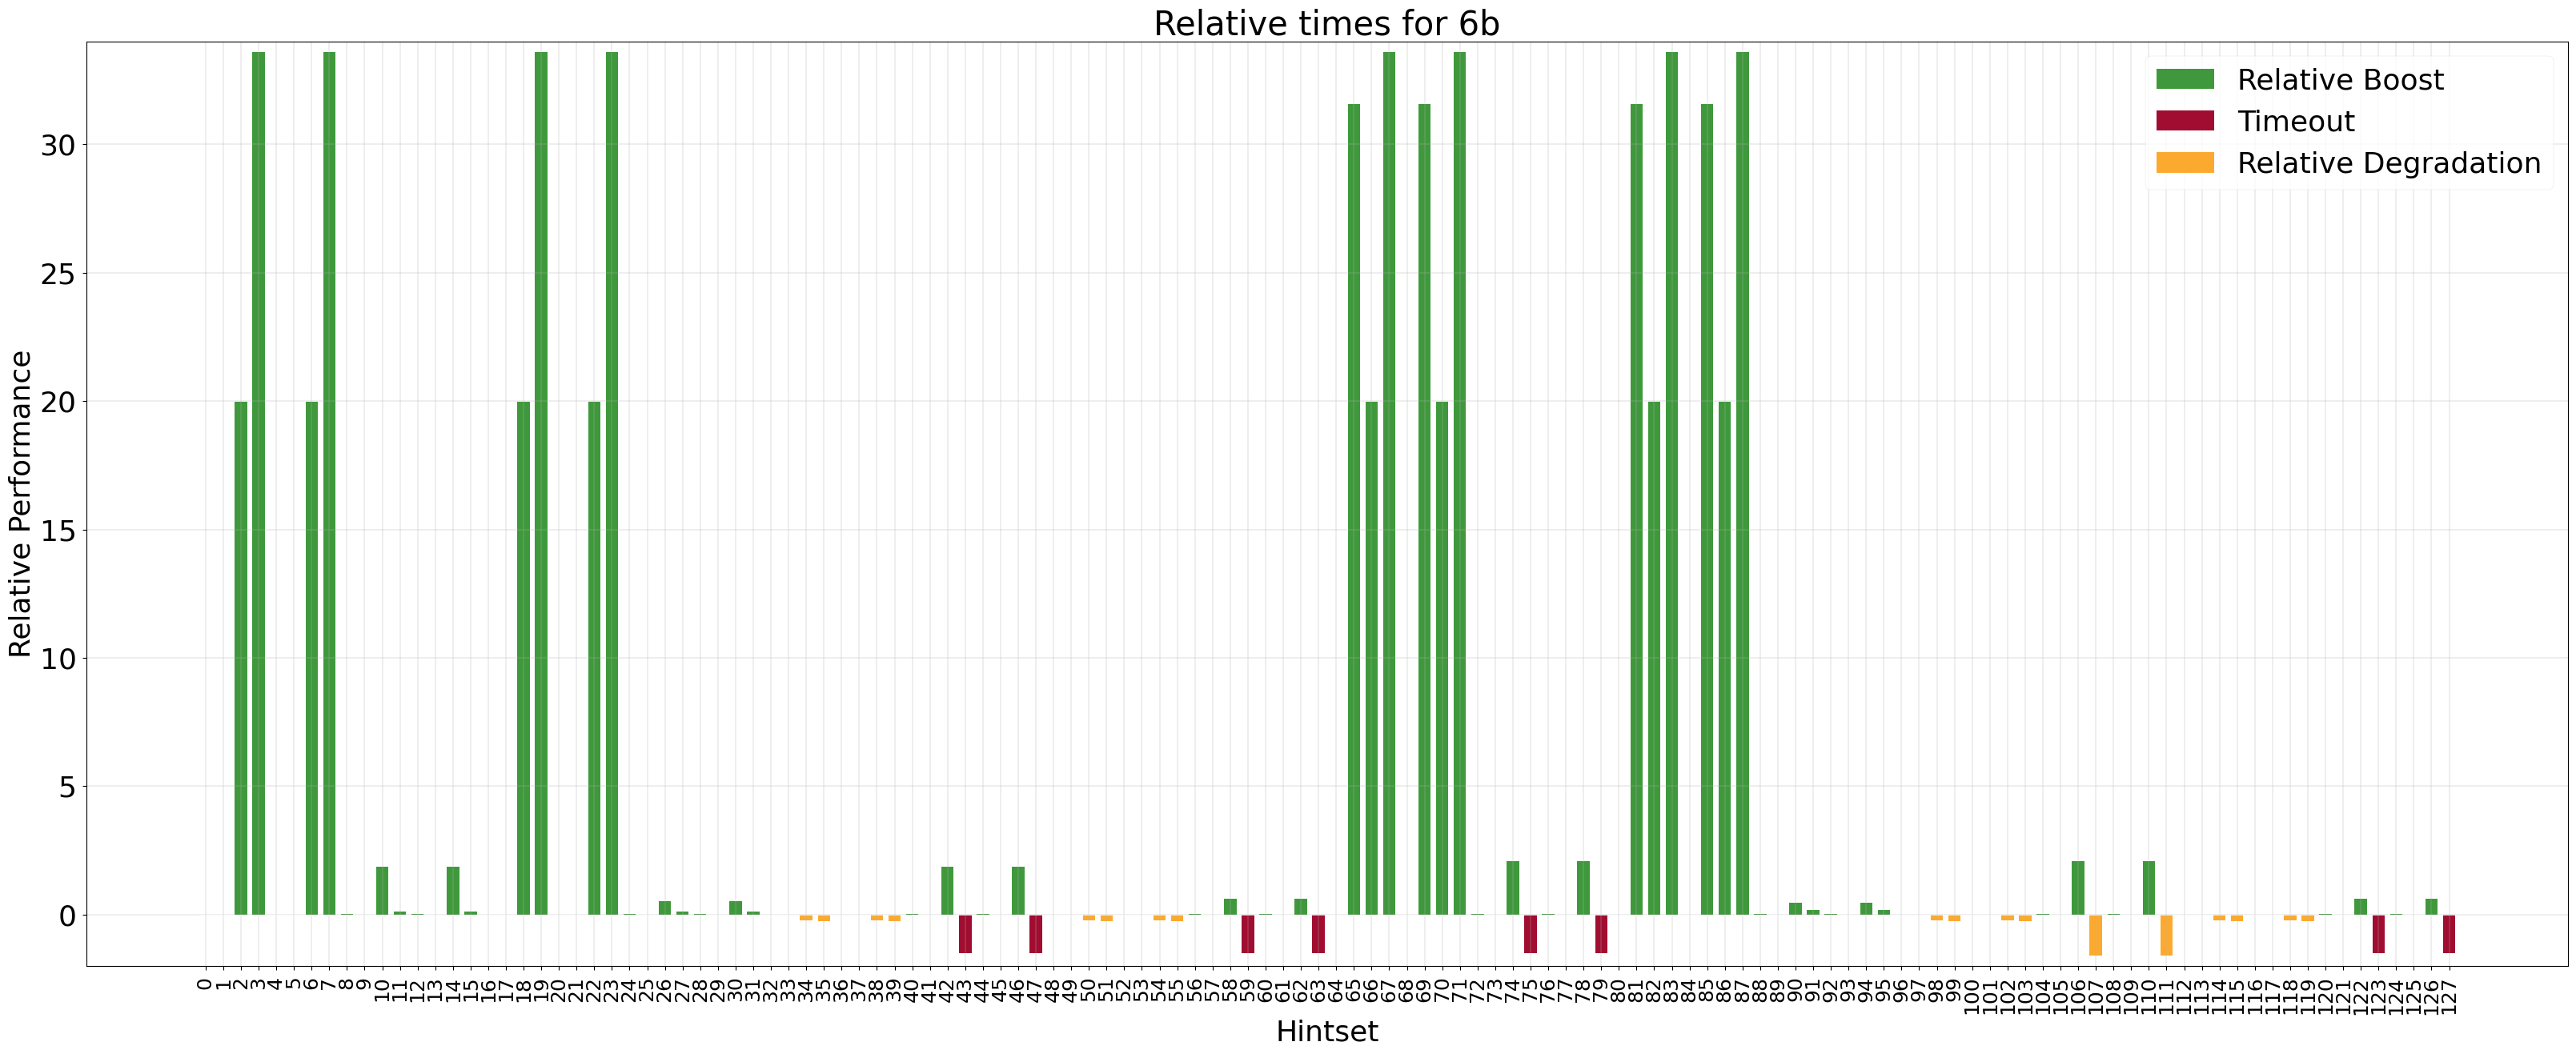

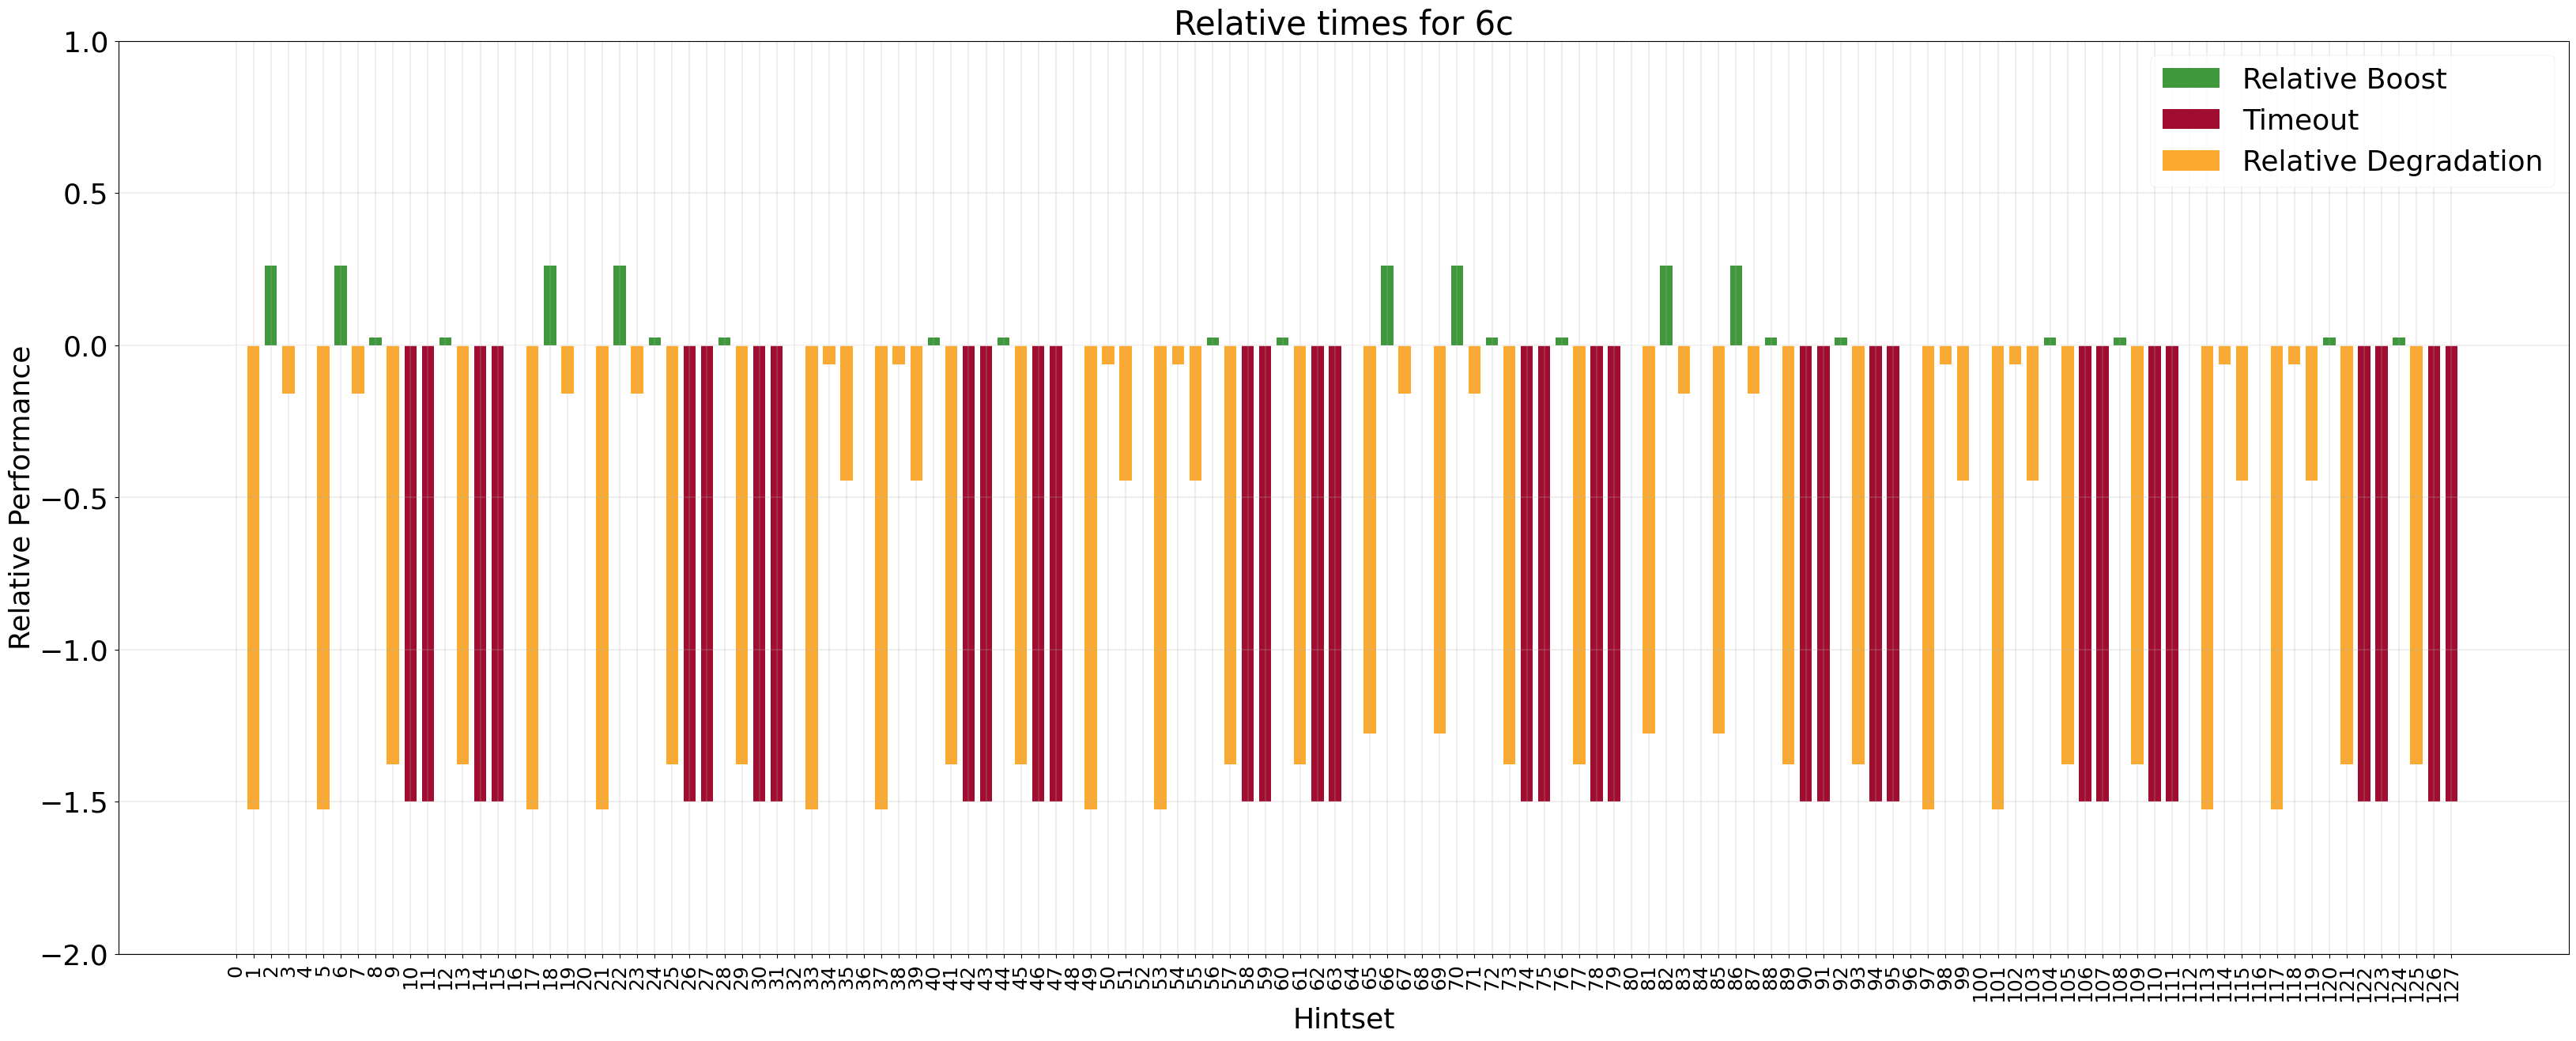

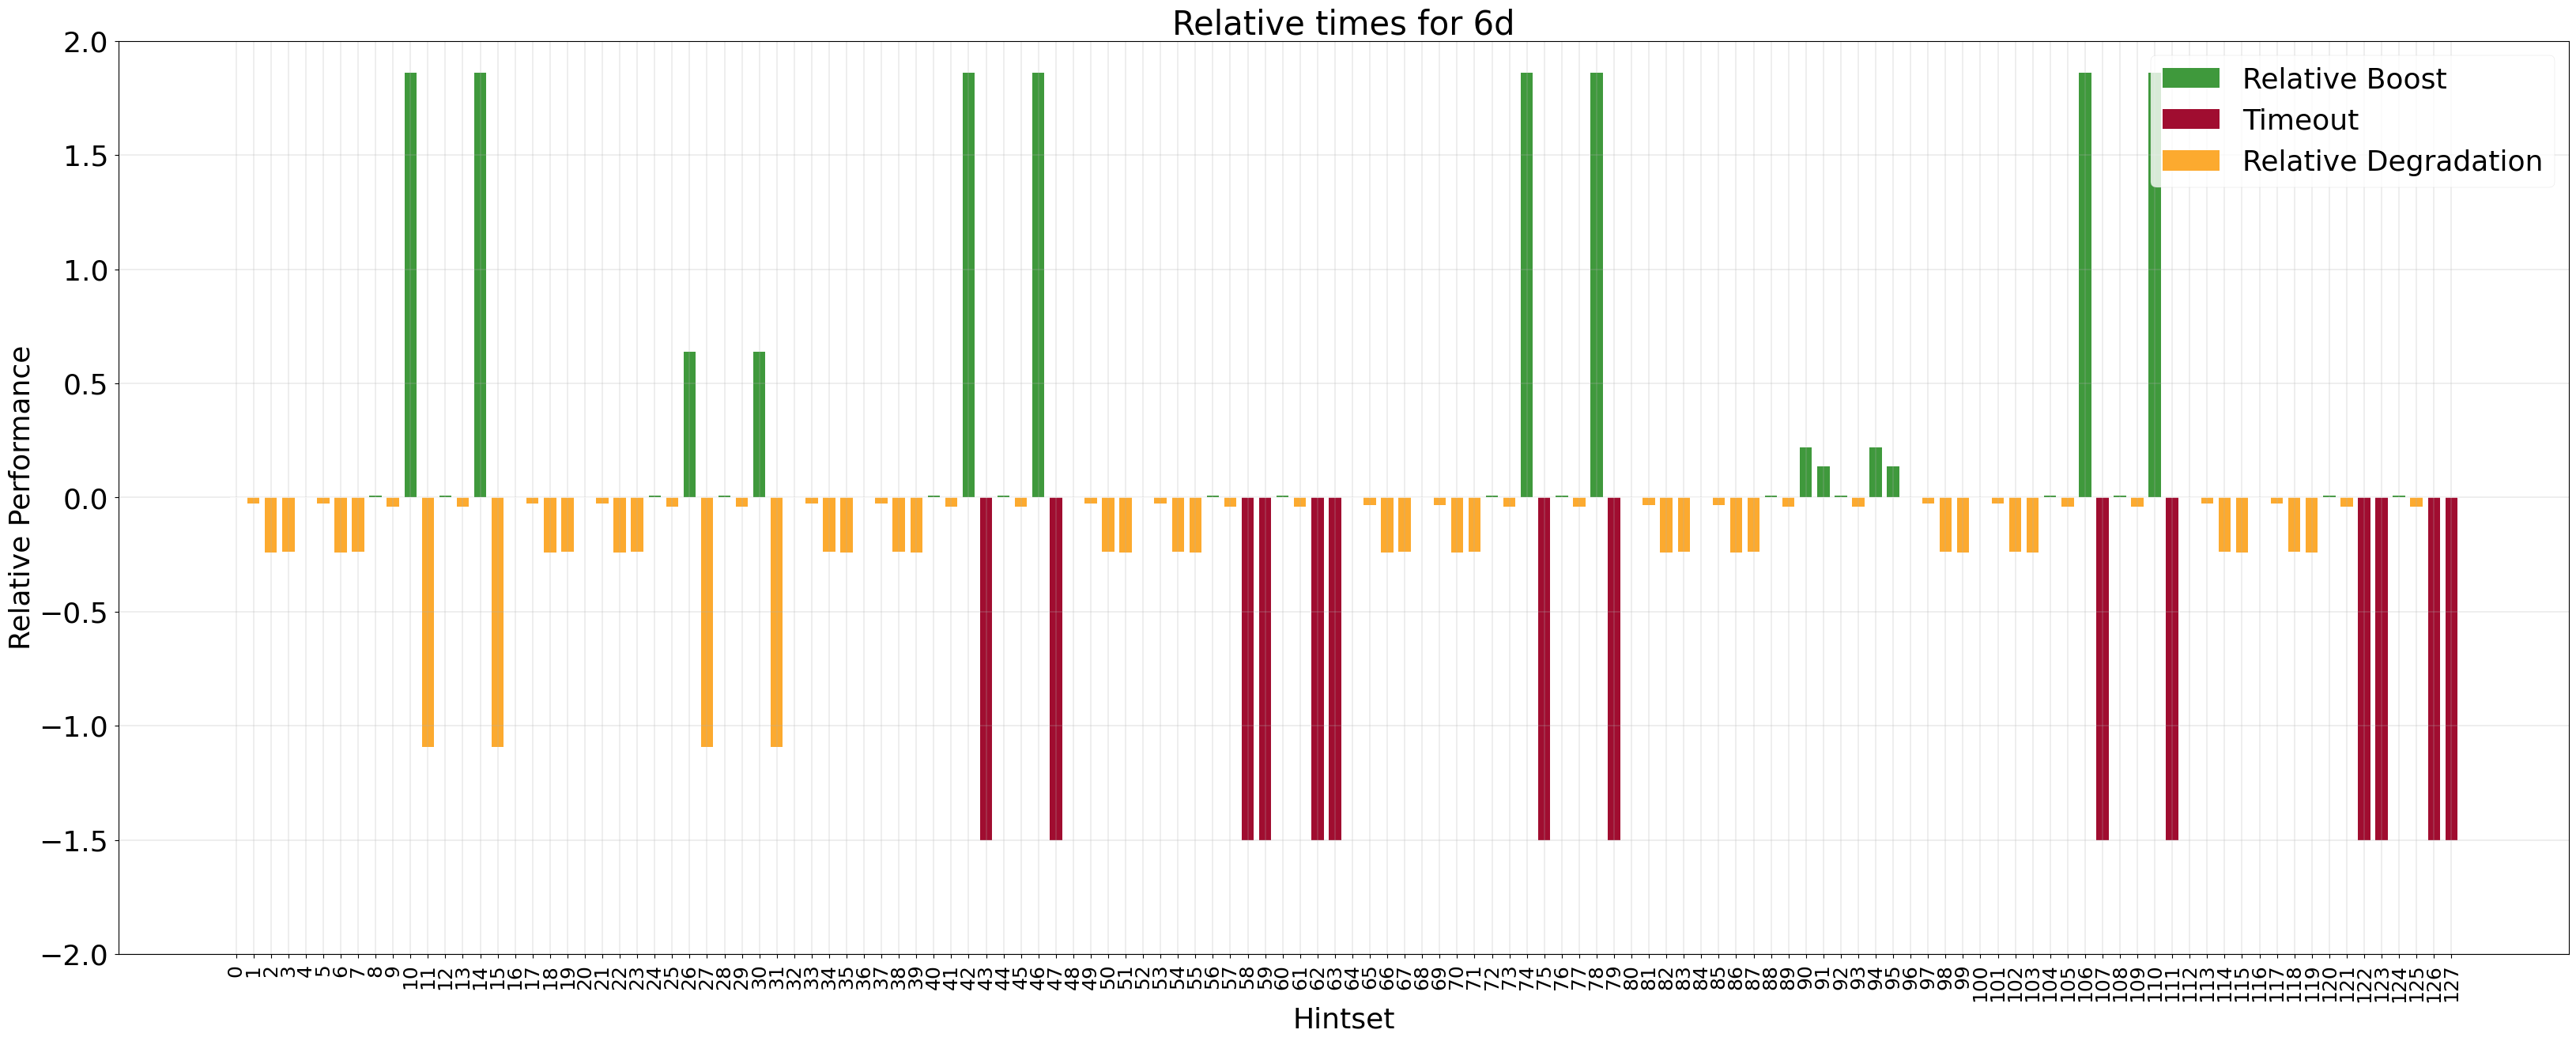

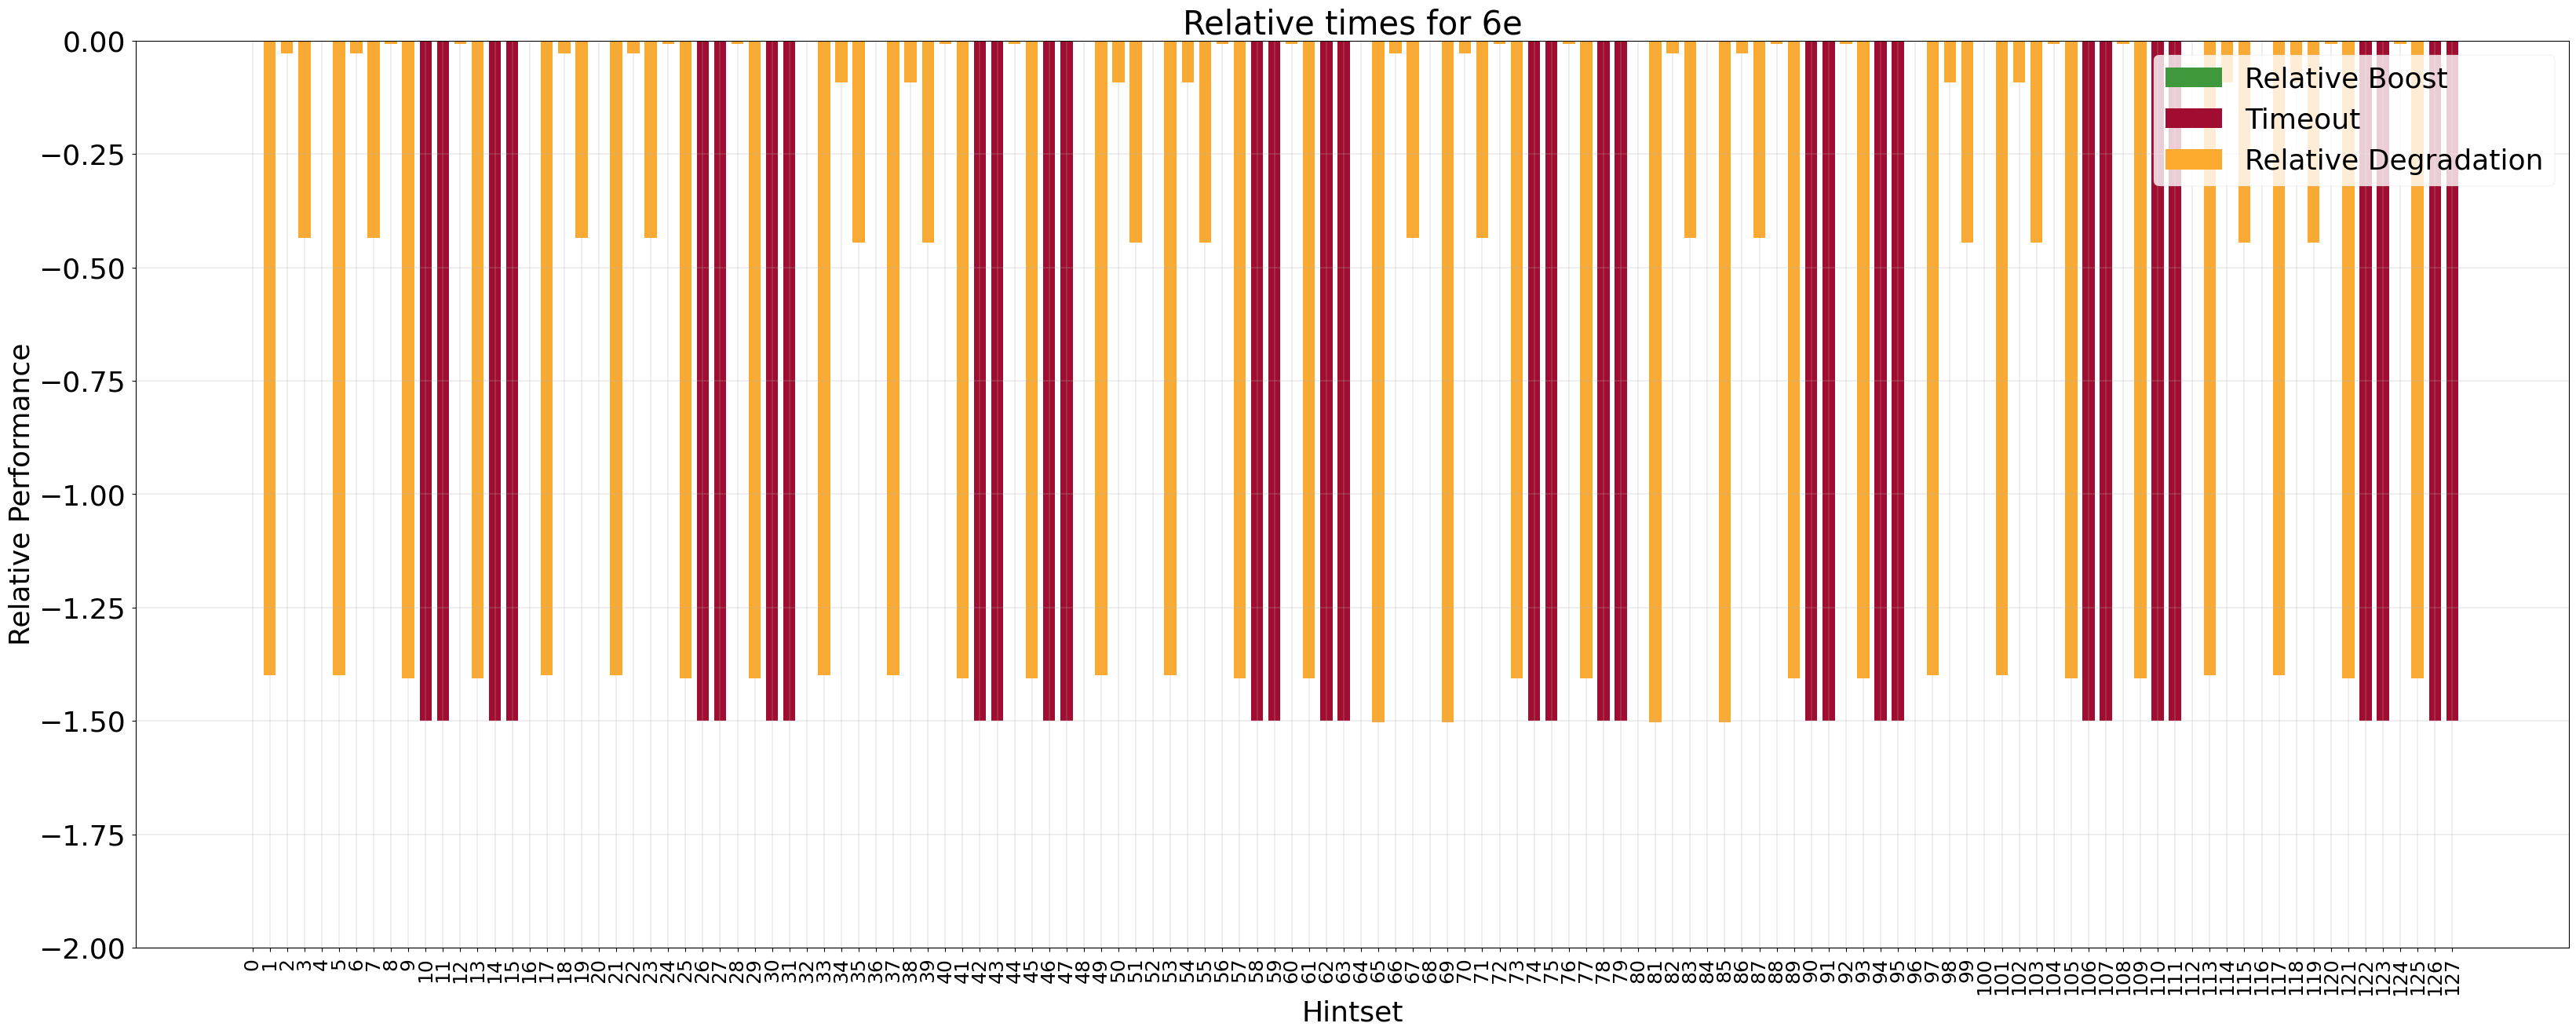

In [12]:
DEFAULT_DOP = 64
estimate_negative_impact("6b", "6d")
plot_boosts_for_all_hintsets(["6b", "6c", "6d", "6e",], logscale=False)

**Conclusions:**

In the case of the most suitable query for hint-based optimization (`16b`: from 70sec to 30sec) we have risks to get regression on the similar query `16d` and in 20% of usefull for `16b` hintsets we have TIMEOUT for `16d`. 

If we uniformly pick any good for `16b` hintset, the expected degradation for `16d` is about x `1.33`.